# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import os
from torchvision import datasets
import torch.optim as optim
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [4]:


# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


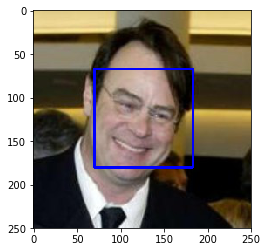

In [5]:
                             

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [22]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
Detected dogs: 17.0%
Detected faces: 98.0%

In [6]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

In [8]:
from tqdm import tqdm


#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
dogs = 0
faces = 0


for dog in dog_files_short:
    dogs += face_detector(dog)

procent_dogs = dogs/len(dog_files_short)*100
    
print("Detected dogs: {}%".format(procent_dogs))

for human in human_files_short:
      faces += face_detector(human)


procent_faces = faces/len(human_files_short)*100
print("Detected faces: {}%".format(procent_faces))



Detected dogs: 17.0%
Detected faces: 98.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [56]:


# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [60]:


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    #img = cv2.imread(img_path)
    img = Image.open(img_path)
    
    img_transforms=transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std = [0.229, 0.224, 0.225])])
    #img=cv2.resize(img,(224, 224))
    img= img_transforms(img).unsqueeze(0)
    #print(type(img))
    preds = VGG16(img.cuda())
    top_p, top_class = preds.topk(1,dim = 1)
    
    return top_class # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [5]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    preds =VGG16_predict(img_path)
    #print(preds.item())
    if preds.item() in range(151, 269):
        
        return True
    else:
        
        return False# true/false
    

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [62]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs_d = 0
dogs_h = 0

for dog in human_files_short:
    if dog_detector(dog) == True:
        dogs_h=dogs_h+1
        
procent_dogs_humanfiles = dogs_h/len(human_files_short)*100
    
print("Detected dogs in human files: {}%".format(procent_dogs_humanfiles))

for dog in dog_files_short:
    if dog_detector(dog) == True:
        dogs_d=dogs_d+1


procent_dogs_dogfiles = dogs_d/len(dog_files_short)*100
print("Detected dogs in dog files: {}%".format(procent_dogs_dogfiles))


Detected dogs in human files: 1.0%
Detected dogs in dog files: 97.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [7]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.
   

def isdog_predict(img_path, modelname):
    '''
    Use pre-trained model to detect a dog is present in an image
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    if modelname=='densenet121':
        model = models.densenet121(pretrained=True)     
    elif modelname == 'resnet50':
        model =models.resnet50(pretrained=True)
    elif modelname == 'resnet18':
        model =models.resnet18(pretrained=True)
    elif modelname == 'VGG16':
        model =models.vgg16(pretrained=True)
        
    else:
        return print('Model not found')
        
    img = Image.open(img_path)
    img_transforms=transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std = [0.229, 0.224, 0.225])])

    img= img_transforms(img).unsqueeze(0)
    
    model.eval()
    preds = model(img)
    preds= preds.cpu()
    #top_p, top_class = preds.topk(1,dim = 1)
    top_p, top_class = torch.max(preds, 1)
    if top_class.item() in range(151, 269): 
        #print('true', top_class.item())
        return True
    else:
        #print('false', top_class.item())
        return False
    



In [13]:
#calculate prediction percentage for Resnet50
dogs_d = 0
dogs_h = 0

for dog in human_files_short:
     if isdog_predict(dog, "resnet50") == True:
        dogs_h=dogs_h+1
         
procent_dogs_humanfiles = dogs_h/len(human_files_short)*100

print("Detected dogs in human files: {}%".format(procent_dogs_humanfiles))

for dog in dog_files_short:
    if isdog_predict(dog, "resnet50") == True:
        dogs_d=dogs_d+1
            
procent_dogs_dogfiles = dogs_d/len(dog_files_short)*100
print("Detected dogs in dog files: {}%".format(procent_dogs_dogfiles))
    

Detected dogs in human files: 1.0%
Detected dogs in dog files: 97.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [8]:


### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = '/data/dog_images/'
batch_size=8

# TODO: Define transforms for the training data and testing data
data_transforms = {
    'train' : transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),
    'valid' : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])]),
     'test' : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])}




# Pass transforms in here, then run the next cell to see how the transforms look
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}

loaders_scratch = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
                   for x in ['train', 'valid',  'test']}



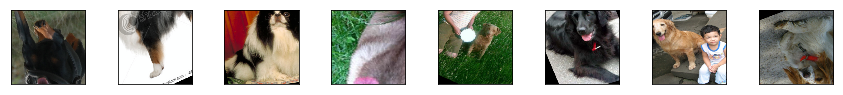

In [5]:
# showing some samples of aumented images
# obtain one batch of training images
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(15, 3))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    inp = images[idx].transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(np.clip(inp, 0, 1))


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
I have chosen to random crop and resize the images to the 224x224 image which I reused in the later transfer learning part. I have cropped and resize and augmented the dataset by horizontally and vertically flipping the images to provide more data for my CNN, you can see funny results above.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        #convolutional layer (sees 112x112x64 tensor)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        #convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        #convolutional layer (sees 28x28x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        #convolutional layer (sees 14x14x128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layers 
        self.fc1 = nn.Linear(256 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 133)
        self.relu = nn.ReLU()
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        ## Define forward behavior
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print('conv1:', x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('conv2:', x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        #print('conv3:', x.shape)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        #print('conv4:', x.shape)

        # flatten image input
        
        x = x.view(-1, 256 * 7 * 7)
        #print('new shape:', x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        #print('shape fc2:', x.shape)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I have 5 layers of convolutional network with kernel size 3x3, with 256 output layers. The maxpooling layer decreases the image by factor of 2 each time so at the end the final output of the last CNN is 256 layers of 7*7. These layers are passed throught 2 fully connected layers with output 133 features which are the dog classes. I added a dropout of 0.2.
I  started at first with 4 layers and with less output layers in the CNN but the results were really poor. By increasing the output layers the CNN seemed to do a better job.
I got the idea of this architecture by looking at the first layers of the Resnet50 which I am using later in this notebook.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [9]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                       
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)            
            # calculate the loss            
            loss = criterion(output, target)            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss         
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # calculate average validation loss over an epoch
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 
            
    # return trained model
    return model





In [ ]:

# train the model
model_scratch = train(70, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.888140 	Validation Loss: 4.880118
Validation loss decreased (inf --> 4.880118).  Saving model ...
Epoch: 2 	Training Loss: 4.868688 	Validation Loss: 4.849420
Validation loss decreased (4.880118 --> 4.849420).  Saving model ...
Epoch: 3 	Training Loss: 4.827316 	Validation Loss: 4.783770
Validation loss decreased (4.849420 --> 4.783770).  Saving model ...
Epoch: 4 	Training Loss: 4.751921 	Validation Loss: 4.687581
Validation loss decreased (4.783770 --> 4.687581).  Saving model ...
Epoch: 5 	Training Loss: 4.715970 	Validation Loss: 4.651063
Validation loss decreased (4.687581 --> 4.651063).  Saving model ...
Epoch: 6 	Training Loss: 4.687749 	Validation Loss: 4.651174
Epoch: 7 	Training Loss: 4.652778 	Validation Loss: 4.531750
Validation loss decreased (4.651063 --> 4.531750).  Saving model ...
Epoch: 8 	Training Loss: 4.587414 	Validation Loss: 4.457982
Validation loss decreased (4.531750 --> 4.457982).  Saving model ...
Epoch: 9 	Training Loss: 4.543782 

Sorry, the notebook is timing out so it stopped and I did not retrain it once more, as it was taking too long. I am using the best result by loading it again in the model.

In [11]:
# load the model that got the best validation accuracy
state_dict = torch.load('model_scratch.pt')
print(state_dict.keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [12]:
model_scratch = Net()

In [13]:
model_scratch.load_state_dict(state_dict)
model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [15]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.860099


Test Accuracy: 11% (96/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
## TODO: Specify data loaders
batch_size=8
loaders_transfer = loaders_scratch
class_names = image_datasets['train'].classes

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [11]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

In [12]:

from collections import OrderedDict
n_epochs=10
n_inputs = 2048

# new layers automatically have requires_grad = True
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.4)),
                          ('fc2', nn.Linear(500, 133)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model_transfer.fc = classifier

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()


print(model_transfer.fc)

Sequential(
  (fc1): Linear(in_features=2048, out_features=500, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (output): LogSoftmax()
)


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I this case the ResNet50 is pretrained on 1.28 million images, also dogs.
I reused the previous dataloaders with the same transformations, as they were already resized and trasformed appropriately for this network.
I replaced the last fully connected layer with two fully connected layers ouputting the right amount of features for the 133 classes. I hadded a dropout of 40%. 
I specified a LogSoftmax layer to go with the NNLloss function and SGD optimizer with a learning rate of 0.001 which seemed to work really well.

This delivered quite a good accuracy within 5 epochs, so I did train it again with 10 epochs which delivered even better results.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [13]:
criterion_transfer =  nn.NLLLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [14]:
# train the model
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.446394 	Validation Loss: 2.544332
Validation loss decreased (inf --> 2.544332).  Saving model ...
Epoch: 2 	Training Loss: 3.019571 	Validation Loss: 1.329586
Validation loss decreased (2.544332 --> 1.329586).  Saving model ...
Epoch: 3 	Training Loss: 2.417032 	Validation Loss: 1.059343
Validation loss decreased (1.329586 --> 1.059343).  Saving model ...
Epoch: 4 	Training Loss: 2.149816 	Validation Loss: 0.909897
Validation loss decreased (1.059343 --> 0.909897).  Saving model ...
Epoch: 5 	Training Loss: 1.999292 	Validation Loss: 0.839671
Validation loss decreased (0.909897 --> 0.839671).  Saving model ...
Epoch: 6 	Training Loss: 1.887494 	Validation Loss: 0.777705
Validation loss decreased (0.839671 --> 0.777705).  Saving model ...
Epoch: 7 	Training Loss: 1.794238 	Validation Loss: 0.827211
Epoch: 8 	Training Loss: 1.737701 	Validation Loss: 0.787738
Epoch: 9 	Training Loss: 1.661609 	Validation Loss: 0.758431
Validation loss decreased (0.777705 --> 0.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [17]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.796465


Test Accuracy: 74% (623/836)


In [53]:
#track test loss, code from cifar10_cnn lesson

def test2(model):
    test_loss = 0.0
    class_correct = list(0. for i in range(133))
    class_total = list(0. for i in range(133))
  
    model.eval() # eval mode
    # iterate over test data
    for data, target in loaders_transfer['valid']:

      # move tensors to GPU if CUDA is available
        if use_cuda:
             data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        # update  test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        # compare predictions to true class
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
          # calculate test accuracy for each object class
        for i in range(len(data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate avg test loss
    test_loss = test_loss/len(loaders_transfer['valid'].dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
  
    for i in range(133):
        if class_total[i] > 0:
            print('Accuracy of %5s: %2d%% (%2d/%2d)' % (
            class_names[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Accuracy of %5s: N/A (no training examples)' % (class_names[i]))
            
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
         100. * np.sum(class_correct) / np.sum(class_total),
         np.sum(class_correct), np.sum(class_total)))  

In [22]:
# after 10 epochs
test2(model_transfer)

Test Loss: 0.682843

Accuracy of 001.Affenpinscher: 87% ( 7/ 8)
Accuracy of 002.Afghan_hound: 57% ( 4/ 7)
Accuracy of 003.Airedale_terrier: 100% ( 7/ 7)
Accuracy of 004.Akita: 87% ( 7/ 8)
Accuracy of 005.Alaskan_malamute: 100% ( 9/ 9)
Accuracy of 006.American_eskimo_dog: 100% ( 8/ 8)
Accuracy of 007.American_foxhound: 16% ( 1/ 6)
Accuracy of 008.American_staffordshire_terrier: 75% ( 6/ 8)
Accuracy of 009.American_water_spaniel: 25% ( 1/ 4)
Accuracy of 010.Anatolian_shepherd_dog: 100% ( 6/ 6)
Accuracy of 011.Australian_cattle_dog: 100% ( 8/ 8)
Accuracy of 012.Australian_shepherd: 100% ( 8/ 8)
Accuracy of 013.Australian_terrier: 66% ( 4/ 6)
Accuracy of 014.Basenji: 87% ( 7/ 8)
Accuracy of 015.Basset_hound: 88% ( 8/ 9)
Accuracy of 016.Beagle: 100% ( 7/ 7)
Accuracy of 017.Bearded_collie: 100% ( 7/ 7)
Accuracy of 018.Beauceron: 50% ( 3/ 6)
Accuracy of 019.Bedlington_terrier: 50% ( 3/ 6)
Accuracy of 020.Belgian_malinois: 62% ( 5/ 8)
Accuracy of 021.Belgian_sheepdog: 100% ( 8/ 8)
Accuracy of 

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [66]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [24]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    img = Image.open(img_path)
    img_transforms= data_transforms['valid']
    img= img_transforms(img).numpy()
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    img_input = image_tensor.unsqueeze(0)
    model_transfer.eval()
    probs = torch.exp(model_transfer.forward(img_input.cuda()))
    top_probs, top_class = probs.topk(1, dim=1)
    prediction=class_names[top_class.item()]
    return prediction

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [19]:
### App for face and dog recognition, do you look like a dog??

def run_app(img_path):
    
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path):
        
        result = predict_breed_transfer(img_path)
        print(result)
        # extract pre-trained face detector
        face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

        # load color (BGR) image
        img = cv2.imread(img_path)
        # convert BGR image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find faces in image
        faces = face_cascade.detectMultiScale(gray)

        # print number of faces detected in the image
        print('Hi there, you are human but...')

          # get bounding box for each detected face
        for (x,y,w,h) in faces:
            # add bounding box to color image
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

          # convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print('you look like a {}'.format(result))
          # display the image, along with bounding box
        plt.imshow(cv_rgb)
        plt.show()   
      
     
    elif isdog_predict(img_path, "resnet50"):
        result = predict_breed_transfer(img_path)
        #print(result)
        print('This is a real {}'.format(result))
        img = cv2.imread(img_path)
        plt.imshow(img)
        plt.show()
    
    else:
        img = cv2.imread(img_path)
        print('I cannot detect a dog or a human in this image')
        plt.imshow(img)
        plt.show()
            
   
      
         
  

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The algorithm is quite accurate for these three files. This is because the Bullmastiff category scores quite high the foto's are showing with the right class name. 
To improve it, I could do the following:
- train longer (more epochs)
- try different learning rates during training for example after 20 epochs decrease it
- try various combinations of optimization or loss functions 
- add extra transforms
- remove some of the layers of the pre-trained network, for example keeping the starting ones, add a fully connected layer at the end, freeze the pretrained layers and optimize and update the last layers.

In [26]:
from glob import glob
testphotos = np.array(glob("./testphotos/*"))

This is a real Komondor


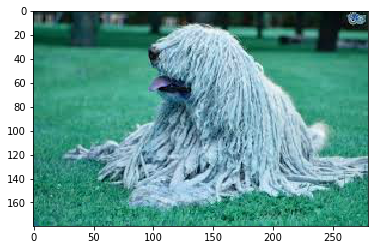

Alaskan malamute
Hi there, you are human but...
you look like a Alaskan malamute


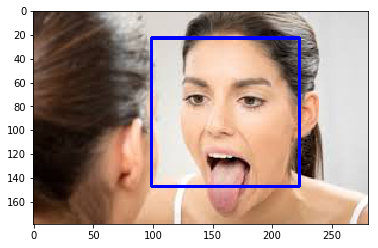

I cannot detect a dog or a human in this image


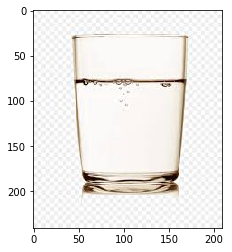

This is a real Alaskan malamute


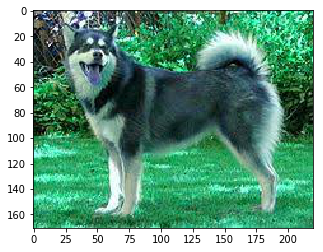

I cannot detect a dog or a human in this image


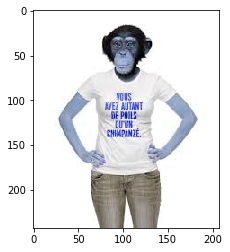

Cavalier king charles spaniel
Hi there, you are human but...
you look like a Cavalier king charles spaniel


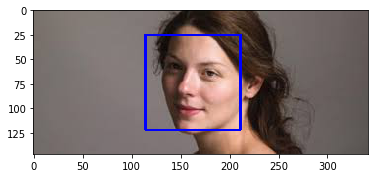

In [27]:
## Execute your algorithm from Step 6 on
## at least 6 images on your computer.

## suggested code, below
for file in np.hstack((testphotos[:6])):
    run_app(file)

This is a real Komondor


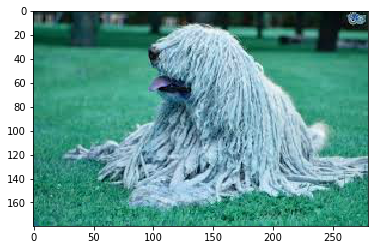

In [28]:
run_app('./images/komondor.jpg')

This is a real Alaskan malamute


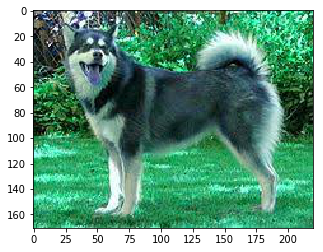

In [29]:
run_app('./images/alskanMalamute1.jpg')